<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm Comparative Assessment</h1> 
<h2 style="text-align: center;" markdown="3">Part 1: Malawi Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
[Data Setup](#data-setup)  
[Model Results using Simple Feature Set](#simple)  
[Model Results using Full Feature Set](#full)  
[Model Results including Tuning, CV, and Feature Selection](#all)  
[Summary](#summary)



# Introduction <a class="anchor" id="introduction"></a>

Now that we have implemented all ten algorithms, we can bring all the results together for a final comparative assessment. As we compare the performance of these classifiers, there are a few things to keep in mind:
* Each algorithm has specific benefits and drawbacks. Though we are making a quantitative assessment based on several metrics, there are tradeoffs that should be considered, such as which metric we are most concerned with in a particular scenario, computational efficiency, and the ability to rank and select features.
* Though we demonstrate feature tuning and some model augmentation techniques for each algorithm, this project does not seek to find the optimum implementation of each model. It is very likely that with more detailed model development and feature engineering, certain algorithms could reach a higher level of performance on this dataset. We only seek to build a baseline comparison in this project.

# Data Setup <a class="anchor" id="data-setup"></a>

All of our model results are stored in the `models` directory and in their respective country folder. To compare results, we have built a few helpful functions within the `evaluation` and `visualization` directories that will help us load the models we want to compare and plot their metrics.

In [1]:
%matplotlib inline

import os
import sys
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from visualization import visualize
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

COUNTRY = 'mwi'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 1
%aimport models.evaluation
%aimport visualization.visualize

# Model Results using Simple Feature Set <a class="anchor" id="simple"></a>

We'll begin by comparing the results of all models using the simple feature set. To give a basic idea of model rank, we rank each model metric from best to worst and take the average across all metrics. 

This gives us a general idea of how the default models perform using only a small subset of features for this problem.

In [3]:
files = os.listdir(os.path.join(evaluation.MODELS_DIR, COUNTRY))
models = [f[:-4] for f in files if f[-4:] == '.pkl']
models = [f for f in models if f[-6:] == 'simple']

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error,mean_rank
mlp_simple,0.77393,0.770622,0.739583,0.754784,0.46695,0.853886,0.545251,0.0596333,1.75
xgb_simple,0.764783,0.752533,0.733427,0.742857,0.476656,0.847671,0.526186,0.0554231,3.375
lr_simple,0.766743,0.738784,0.743086,0.740929,0.478969,0.847856,0.528811,0.0402688,3.5
dl_simple,0.749428,0.907381,0.662441,0.765802,0.504059,0.848825,0.510115,0.182519,4.5
lda_simple,0.763149,0.735166,0.738909,0.737033,0.488056,0.844833,0.521582,0.0466484,5.25
svm_simple,0.762823,0.746744,0.732955,0.739785,0.489412,0.841742,0.521933,0.0475963,5.25
lr_logit_simple,0.756615,0.662808,0.766527,0.710904,0.483052,0.847086,0.502653,-0.0329456,6.75
rf_simple,0.745181,0.724313,0.715,0.719626,1.10248,0.810679,0.486111,0.0397617,8
nb_simple,0.739628,0.728654,0.704689,0.716471,0.527678,0.805111,0.475883,0.0344739,8.5
knn_simple,0.718719,0.72576,0.675421,0.699686,1.59216,0.774297,0.435811,0.0646139,9.125


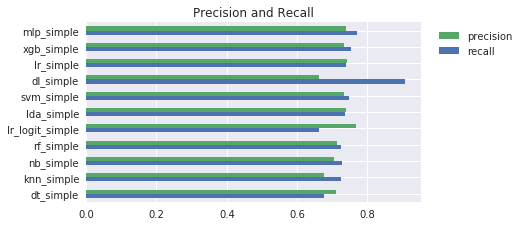

In [4]:
metrics = [evaluation.load_model_metrics(f, COUNTRY) for f in models]
results = visualize.display_model_comparison(metrics, 
                                             show_roc=False, 
                                             show_cm=False, 
                                             show_pov_rate_error=True, 
                                             highlight_best=True, 
                                             transpose=True, 
                                             rank_order=True)
visualize.display_precision_recall(results)

In the results above, it appears that the MLP model gives us the highest average performance across metrics. It has a fairly high recall, which we are concerned with for this problem, and also maintains a fairly high precision rate. 

We may be more interested in a model that gives us a higher level of recall so we are correctly classifying 'poor' households as much as possible. In this case, the deep learning model significantly outperforms the others, as seen in the precision and recall comparison chart. It has the lowest precision rate, though, so we are classifying a larger number of non-poor households as poor than with other models. 

Since several models give us some idea of feature importance or ranking, we can also to evaluate which features are most influential across models. We use a similar ranking method as with the metrics, where we'll take the models that give us a quantitative ranking and average the rank across all. 

As a reminder, the following models gave us an idea of feature ranking, either by the coefficients or the feature importances:

Model | abs(coef*stdev) | feature importance
--- | ---
Logistic Regression | ✓ | 
LDA | ✓ |
KNN | | 
Naive Bayes | |
SVM | |
Decision Trees | | ✓
Random Forests | | ✓
XGBoost | | ✓
MLP | | 
Deep Learning | |

In [5]:
feats = evaluation.load_feats(models, COUNTRY)
visualize.display_feat_ranks(feats);

,dt_simple,lda_simple,lr_logit_simple,lr_simple,rf_simple,xgb_simple,mean_rank,count
der_nchild10under,1,1,1,1,1,1,1,6
der_nliterate,3,2,3,4,2,2,2.66667,6
cons_0508__Yes,2,4,4,3,4,5,3.66667,6
der_nfemalesover10,5,5,5,5,3,4,4.5,6
der_nmalesover10,4,3,6,6,5,3,4.5,6
hld_electricity__Yes,8,8,2,2,8,6,5.66667,6
cons_0504__Yes,6,6,7,7,6,7,6.5,6
der_nemployedpastyear,7,7,8,8,7,8,7.5,6
hld_toilet__None,9,9,9,9,9,9,9,6


# Model Results using Full Feature Set <a class="anchor" id="full"></a>

Now let's examine how the models performed with default settings on the full feature set. 

In [6]:
files = os.listdir(os.path.join(evaluation.MODELS_DIR, COUNTRY))
models = [f[:-4] for f in files if f[-4:] == '.pkl']
models = [f for f in models if f[-len('full'):] == 'full']

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error,mean_rank
xgb_full,0.859814,0.886085,0.862249,0.874005,0.321812,0.937449,0.731838,0.01896,3.125
lr_full,0.873897,0.869754,0.853693,0.861649,0.288223,0.948658,0.745821,0.00997812,3.375
mlp_full,0.865478,0.88355,0.872856,0.87817,0.641859,0.94137,0.73721,0.00165313,3.5
lda_full,0.859154,0.883628,0.862976,0.87318,0.326524,0.934298,0.719414,0.0147335,3.875
dl_full,0.853374,0.934514,0.822464,0.874916,0.756312,0.927875,0.718693,0.0512043,4.5
svm_full,0.846032,0.860206,0.859345,0.859775,0.342397,0.926992,0.671944,0.00829953,6
rf_full,0.831522,0.863785,0.834896,0.849095,0.392563,0.920024,0.662545,0.0206509,6.25
knn_full,0.745905,0.971254,0.691005,0.807505,0.68906,0.881738,0.430777,0.235539,7
nb_full,0.793732,0.859345,0.785084,0.820538,2.4725,0.873451,0.508651,0.0498593,8
dt_full,0.781342,0.788032,0.808616,0.798192,3.56614,0.824372,0.571708,-0.00718927,9.375


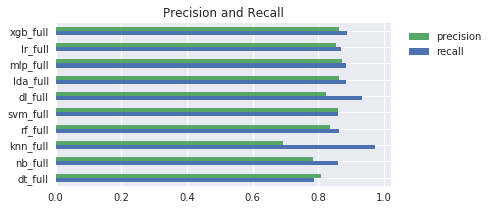

In [7]:
metrics = [evaluation.load_model_metrics(f, COUNTRY) for f in models]
results = visualize.display_model_comparison(metrics, 
                                             show_roc=False, 
                                             show_cm=False, 
                                             show_pov_rate_error=True, 
                                             highlight_best=True, 
                                             transpose=True, 
                                             rank_order=True)
visualize.display_precision_recall(results)

With the full feature set, the Support Vector Machine model appears to rise to the top in performance, with the highest f-score and relatively high recall and precision, though the XGBoost model is very comparable.

In terms of recall, the KNN model is significantly better, but has the lowest precision of all models and gives us the least accurate national poverty rate estimate. As with the simple feature set, the deep learning model also gives a high recall rate and a relatively high precision. 

It is interesting to note that the basic Logistic Regression model is one of the strongest candidates, with metrics comparable to both SVM and XGB. 

When we compare feature ranking across all models that provide them, 

In [8]:
feats = evaluation.load_feats(models, COUNTRY)
feat_rankings = visualize.display_feat_ranks(feats);

,dt_full,lda_full,lr_full,rf_full,xgb_full,mean_rank,count
der_hhsize,2,1,1,1,1,1.2,5
cons_0508__Yes,4,8,2,12,3,5.8,5
hld_nbcellpho,10,10,3,8,9,8,5
cons_0505__Yes,9,11,5,23,7.5,11.1,5
cons_1108__Yes,6,27,4,22,5.5,12.9,5
cons_0106__Yes,25,16,9,10,10.5,14.1,5
cons_0801__Yes,1,13,37,3,22,15.2,5
cons_0111__Yes,3,39,13,7,18,16,5
hld_rooms,12,21,10,40,4,17.4,5
cons_0501__Yes,7,40,29,4,14,18.8,5


Though no model ranks the features exactly the same, there are certainly some features that have a stronger impact on the outcome across all models. In terms of consumables, we can filter this list out and examine the top 50.

In [9]:
cons_feats = feat_rankings[feat_rankings.index.str.contains('cons')]['mean_rank'].iloc[0:50]
print("Top {} consumables features:".format(len(cons_feats)))
cons_feats_top50 = cons_feats.copy()
cons_feats.index = cons_feats.index.map(lambda x: questions[x.split('__')[0]])
cons_feats

Top 50 consumables features:


Chicken                                                                              5.8
Goat                                                                                11.1
Public transport - Bus/Minibus                                                      12.9
Rice                                                                                14.1
Sugar                                                                               15.2
Bread                                                                               16.0
Eggs                                                                                18.8
Thobwa                                                                              19.3
Pumpkin                                                                             24.1
Banana                                                                              24.6
Tea                                                                                 27.6
Buns, scones         

# Model Results including Tuning, CV, and Feature Selection <a class="anchor" id="all"></a>

Now we will perform a similar comparison with the model results where we included various techniques such as tuning via gridsearch, cross-validation, and feature selection. 

In [10]:
files = os.listdir(os.path.join(evaluation.MODELS_DIR, COUNTRY))
models = [f[:-4] for f in files if f[-4:] == '.pkl']
models = [f for f in models if 'simple' not in f]

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error,mean_rank
mlp_full_cv,0.870865,0.889575,0.876874,0.883179,0.279533,0.950956,0.753925,0.0102651,5.875
xgb_feats,0.872109,0.891584,0.87734,0.884405,0.289181,0.948603,0.754271,0.00847763,5.875
lr_full_wts_cv,0.873458,0.891581,0.87947,0.885484,0.300498,0.944474,0.734446,0.0138185,6.375
xgb_full_cv,0.868765,0.894152,0.87025,0.882039,0.295551,0.947721,0.750765,0.0103505,7
dl_full_cv,0.864962,0.906502,0.855921,0.880486,0.390082,0.944305,0.737508,0.0297718,9.625
xgb_full,0.859814,0.886085,0.862249,0.874005,0.321812,0.937449,0.731838,0.01896,11.5
lr_full,0.873897,0.869754,0.853693,0.861649,0.288223,0.948658,0.745821,0.00997812,11.875
dt_full_wts_cv_ada,0.866051,0.877945,0.877948,0.877947,0.353074,0.941477,0.737008,0.00273764,11.875
rf_full_wts_cv_ada,0.865851,0.885488,0.872018,0.878701,0.594091,0.947686,0.744254,0.00208431,12.125
rf_feats,0.868134,0.871847,0.886018,0.878876,0.474121,0.941116,0.742232,-0.00115567,13


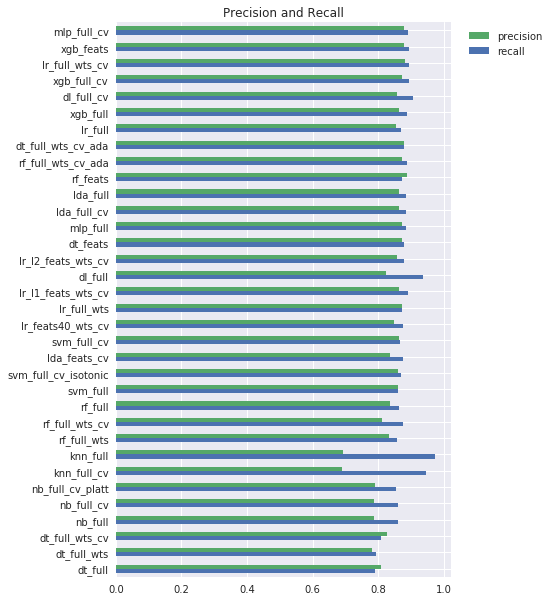

In [11]:
metrics = [evaluation.load_model_metrics(f, COUNTRY) for f in models]
results = visualize.display_model_comparison(metrics, 
                                             show_roc=False, 
                                             show_cm=False, 
                                             show_pov_rate_error=True, 
                                             highlight_best=True, 
                                             transpose=True, 
                                             rank_order=True)
visualize.display_precision_recall(results)

In these results we can see the benefits of using cross-validation and parameter tuning. There does not appear to be a strong winner in the top results, but models such as MLP and SVM rise to the top again. Our baseline Logistic Regression remains near the top in terms of performance as well. 

The deep learning model once again gives us a slight boost in recall while maintaining a reasonable precision rate. 

Let's inspect the feature ranks again and see if there are any significant changes to the list.

In [12]:
feats = evaluation.load_feats(models, COUNTRY)
feat_rankings = visualize.display_feat_ranks(feats);

,dt_feats,dt_full,dt_full_wts,dt_full_wts_cv,dt_full_wts_cv_ada,lda_feats_cv,lda_full,lda_full_cv,lr_feats40_wts_cv,lr_full,lr_full_wts_cv,lr_l1_feats_wts_cv,lr_l2_feats_wts_cv,rf_feats,rf_full,rf_full_wts,rf_full_wts_cv,rf_full_wts_cv_ada,xgb_feats,xgb_full,xgb_full_cv,mean_rank,count
der_hhsize,1,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1.19048,21
cons_0508__Yes,6,4,3,3,5,2,8,8,3,2,4,3,3,8,12,6,7,12,4,3,5,5.28571,21
hld_nbcellpho,9,10,8,9,12,4,10,10,2,3,2,2,2,11,8,11,4,15,7,9,4,7.2381,21
hld_rooms,3,12,10,16,3,nan,21,21,5,10,5,5,6,6,40,38,46,3,2,4,2,12.9,20
cons_0106__Yes,22,25,16,14,17,10,16,16,13,9,8,10,10,9,10,5,8,33,14.5,10.5,15,13.8571,21
cons_0505__Yes,18,9,24,48,14,6,11,11,8,5,6,8,8,nan,23,22,20,nan,9.5,7.5,7,13.9474,19
cons_0801__Yes,10,1,5,4,6,5,13,13,33,37,37,37,44,7,3,3,3,10,37.5,22,41,17.6905,21
cons_0501__Yes,13,7,9,8,10,11,40,40,30,29,27,26,28,12,4,8,11,53,28,14,20,20.381,21
cons_1108__Yes,26,6,6,6,23,8,27,27,6,4,12,7,7,17,22,18,24,143,19,5.5,16,20.4524,21
cons_0602__Yes,5,8,7,7,7,9,43,43,21,45,24,21,30,15,13,20,19,18,48.5,14,22.5,20.9524,21


In nearly every model, features such as the household size, number of cellphones, and rooms in the household appear to be the strongest predictive feature, with `cons_0508` (Chicken) and several other consumables near the top as well. 

Once again, let's filter the top 50 consumables by rank.

In [13]:
cons_feats = feat_rankings[feat_rankings.index.str.contains('cons')]['mean_rank'].iloc[0:50]
print("Top {} consumables features:".format(len(cons_feats)))
cons_feats_top50 = cons_feats.copy()
cons_feats.index = cons_feats.index.map(lambda x: questions[x.split('__')[0]])
cons_feats

Top 50 consumables features:


Chicken                                                                              5.285714
Rice                                                                                13.857143
Goat                                                                                13.947368
Sugar                                                                               17.690476
Eggs                                                                                20.380952
Public transport - Bus/Minibus                                                      20.452381
Banana                                                                              20.952381
Tea                                                                                 21.095238
Pumpkin                                                                             21.975000
Cooking oil                                                                         24.976190
Bread                                                       

The ordering has shifted slightly when incorporating all the models, but most of the same features rise to the top in ranking. 

Recall that with the initial algorithms, the sign of the coefficient gives us an idea for how that feature pushes the result towards a positive or negative class. We can use this information to inform us of whether responding "yes" to these consumables makes the outcome more likely to be `poor` or `non-poor`. Let's filter the list to see which, if any, features would indicate the household being `poor` if the response was "yes"

In [14]:
feat_rankings = []
for key, value in sorted(feats.items()):
    if type(value) == pd.DataFrame:
        if 'coef' in value.columns:
            ranks = (pd.DataFrame(value['coef'].rename(key)))
            feat_rankings.append(ranks)
feat_rankings = pd.concat(feat_rankings, axis=1)
feat_rankings = feat_rankings.loc[cons_feats_top50.index]
feat_rankings.index = feat_rankings.index.map(lambda x: questions[x.split('__')[0]])
feat_rankings[~feat_rankings[feat_rankings > 0].sum(axis=1).apply(pd.isnull)]


,lda_feats_cv,lda_full,lda_full_cv,lr_feats40_wts_cv,lr_full,lr_full_wts_cv,lr_l1_feats_wts_cv,lr_l2_feats_wts_cv
Chicken,-1.129430,-1.026156,-1.026156,-1.421567,-1.532686,-1.202141,-1.147195,-1.215340
Rice,-0.508624,-0.622600,-0.622600,-0.695724,-0.756642,-0.646181,-0.626889,-0.661183
Goat,-0.809299,-0.867497,-0.867497,-1.023410,-1.208559,-0.941744,-0.890883,-0.914467
Sugar,-0.621821,-0.659565,-0.659565,-0.354227,-0.373675,-0.267637,-0.235773,-0.276877
Eggs,-0.491725,-0.383961,-0.383961,-0.388714,-0.461463,-0.319992,-0.316398,-0.366234
Public transport - Bus/Minibus,-0.767191,-0.629556,-0.629556,-1.079851,-1.257543,-0.764633,-0.926760,-0.986971
Banana,-0.544735,-0.371108,-0.371108,-0.515956,-0.340183,-0.317700,-0.353236,-0.345746
Tea,-0.602171,-0.464020,-0.464020,-0.522423,-0.282570,-0.349634,-0.425594,-0.451748
Pumpkin,NaN,-0.622864,-0.622864,-0.836075,-0.850040,-0.780034,-0.639633,-0.686926
Cooking oil,-0.338732,-0.458884,-0.458884,-0.371330,-0.318010,-0.373277,-0.284056,-0.328891


Even with this small set of features, there is not a strong consistency in the sign of the coefficients. Only one, "Grass for thatching roof or other use" appears to consistently push the results towards the household being `poor`

# Malawi Summary <a class="anchor" id="summary"></a>

These notebooks represent an introduction to ten common algorithms for binary classification and a comparative assessment of their performance on the Malawi poverty dataset. Though some algorithms appear to perform better in some aspects, none appears to be significantly superior to the others or to significantly outperform the baseline logistic regression model. 

